# Filesystem Comparison: BenchFS vs CHFS vs BeeOND

This notebook compares IOR benchmark results across three distributed filesystems:
- **BenchFS**: Our Rust-based distributed filesystem
- **CHFS**: Caching ad-hoc parallel file system
- **BeeOND**: BeeGFS On Demand burst buffer filesystem

All data is loaded from `results/{backend}/*/ior_results/ior_result_*.json`.

In [35]:
from pathlib import Path
import json
import re

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from IPython.display import display

# Plot style configuration
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
})
pl.Config.set_tbl_rows(100)

# Colors for each filesystem
FS_COLORS = {
    'benchfs': '#E91E63',  # Pink/Magenta
    'chfs': '#4CAF50',     # Green
    'beeond': '#2196F3',   # Blue
}

FS_MARKERS = {
    'benchfs': 'o',
    'chfs': 's',
    'beeond': '^',
}

FS_LABELS = {
    'benchfs': 'BenchFS',
    'chfs': 'CHFS',
    'beeond': 'BeeOND',
}

DATA_DIR = (Path.cwd() / "processed" / "comparison").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = (Path.cwd() / "fig" / "comparison").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save(fig, name: str) -> None:
    for ext in ("png", "pdf"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight", dpi=150)

def slugify(value: str) -> str:
    cleaned = re.sub(r"[^A-Za-z0-9._-]+", "_", value)
    return cleaned.strip("_") or "unknown"

def parse_size_to_bytes(size_str: str) -> int | None:
    """Parse size string like '4m', '1g' to bytes for sorting."""
    if not size_str:
        return None
    size_str = size_str.lower().strip()
    multipliers = {'k': 1024, 'm': 1024**2, 'g': 1024**3, 't': 1024**4}
    for suffix, mult in multipliers.items():
        if size_str.endswith(suffix):
            try:
                return int(float(size_str[:-1]) * mult)
            except ValueError:
                return None
    try:
        return int(size_str)
    except ValueError:
        return None

In [36]:
# ============================================================
# Experiment Selection
# ============================================================
# Specify experiments to compare. Use None to auto-select latest.
# For fair comparison, select experiments with similar parameters.
#
# Example:
#   BENCHFS_EXPERIMENTS = ["2025.12.24-13.58.42-large_scale"]
#   CHFS_EXPERIMENTS = ["2025.12.04-01.19.09-default"]
#   BEEOND_EXPERIMENTS = ["2025.12.02-11.12.36-large_scale_cppn"]
# ============================================================

BENCHFS_EXPERIMENTS: list[str] | None = [
    # "2025.12.01-16.55.26-large_scale_cppn",
    # "2025.12.01-19.06.35-large_scale_cppn",
    # "2025.12.05-14.49.36-large_scale_cppn",
    # "2025.12.05-17.46.14-large_scale_cppn",
    # "2025.12.06-17.10.08-large_scale",
    # "2025.12.24-13.58.42-large_scale",
    # "2025.12.24-19.07.07-debug_large",
    "2025.12.28-16.02.42-large_scale"
]  
CHFS_EXPERIMENTS: list[str] | None = [
    "2025.12.28-17.02.28-taskset-large-scale",
    "2025.12.29-22.08.20-default"
]
BEEOND_EXPERIMENTS: list[str] | None = [
    "2025.12.01-21.07.50-large_scale_cppn",
    "2025.12.02-11.12.36-large_scale_cppn"
]

In [37]:
def resolve_results_root() -> Path:
    candidates = [
        Path("results"),
        Path("..") / "results",
        Path("../..") / "results",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError("results directory not found.")

results_root = resolve_results_root()
print(f"Using results directory: {results_root}")

Using results directory: /work/0/NBB/rmaeda/workspace/rust/benchfs/results


In [38]:
def fix_ior_json(content: str) -> str:
    """Fix common IOR JSON output format bugs."""
    content = re.sub(r'\]\s*\]\s*,\s*"max":', r'], "max":', content)
    content = re.sub(r'\}\s*\]\s*\]\s*,\s*"summary":', r'}], "summary":', content)
    content = re.sub(r',\s*\}', '}', content)
    content = re.sub(r',\s*\]', ']', content)
    return content

def safe_load_json(path: Path) -> dict | None:
    """Load JSON file with automatic fix for IOR format issues."""
    try:
        content = path.read_text()
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            pass
        fixed_content = fix_ior_json(content)
        return json.loads(fixed_content)
    except (OSError, json.JSONDecodeError) as exc:
        return None

IOR_JSON_PATTERN = re.compile(r"ior_result_(\d+)\.json$")

def parse_number(value):
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        cleaned = value.replace(",", "").strip()
        if cleaned == "":
            return None
        try:
            return float(cleaned)
        except ValueError:
            return None
    return None

def extract_params_from_command(command: str) -> dict:
    """Extract IOR parameters from command line string."""
    params = {}
    match = re.search(r'-t\s+(\S+)', command)
    if match:
        params['transfer_size_str'] = match.group(1)
    match = re.search(r'-b\s+(\S+)', command)
    if match:
        params['block_size_str'] = match.group(1)
    params['file_per_proc'] = 1 if ' -F' in command or command.endswith('-F') else 0
    return params

def extract_nodes_from_run(run_name: str) -> int | None:
    """Extract node count from run directory name."""
    match = re.search(r'-(\d+)$', run_name)
    return int(match.group(1)) if match else None

In [39]:
def load_ior_json_for_backend(root: Path, backend: str) -> pl.DataFrame:
    """Load IOR JSON data for a specific backend."""
    detail_records = []
    
    for path in sorted(root.glob(f"{backend}/**/ior_results/ior_result_*.json")):
        data = safe_load_json(path)
        if data is None:
            continue
            
        rel_parts = path.relative_to(root).parts
        match = IOR_JSON_PATTERN.search(path.name)
        run_index = int(match.group(1)) if match else None
        
        command = data.get("Command line", "")
        cmd_params = extract_params_from_command(command)
        
        run_name = rel_parts[2] if len(rel_parts) > 2 else ""
        nnodes = extract_nodes_from_run(run_name)
        
        base = {
            "backend": backend,
            "experiment": rel_parts[1] if len(rel_parts) > 1 else "",
            "run": run_name,
            "run_index": run_index,
            "nnodes": nnodes,
        }
        
        for test in data.get("tests", []) or []:
            parameters = test.get("Parameters", {}) or {}
            options = test.get("Options", {}) or {}
            results = test.get("Results", []) or []
            
            for result in results:
                if result.get("access") == "remove":
                    continue
                detail_record = base | {
                    "operation": result.get("access"),
                    "bw_mib": parse_number(result.get("bwMiB")),
                    "total_time": parse_number(result.get("totalTime")),
                    "transfer_size_bytes": parameters.get("transferSize"),
                    "block_size_bytes": parameters.get("blockSize"),
                    "num_tasks": options.get("tasks"),
                    "nodes": options.get("nodes"),
                    "tasks_per_node": options.get("clients per node"),
                    "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                    "block_size_str": cmd_params.get("block_size_str", ""),
                    "file_per_proc": cmd_params.get("file_per_proc", 0),
                }
                detail_records.append(detail_record)
                
    df = pl.DataFrame(detail_records) if detail_records else pl.DataFrame([])
    
    if not df.is_empty():
        df = (
            df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("nodes").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                pl.col("nnodes").cast(pl.Int64, strict=False),
                (pl.col("bw_mib") / 1024.0).alias("bw_gib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation"])
        )
        
    return df

# Load data for all backends
benchfs_df = load_ior_json_for_backend(results_root, "benchfs")
chfs_df = load_ior_json_for_backend(results_root, "chfs")
beeond_df = load_ior_json_for_backend(results_root, "beeond")

print(f"Loaded records - BenchFS: {len(benchfs_df)}, CHFS: {len(chfs_df)}, BeeOND: {len(beeond_df)}")

Loaded records - BenchFS: 356, CHFS: 72, BeeOND: 48


In [40]:
def list_experiments(df: pl.DataFrame, backend: str) -> list[str]:
    if df.is_empty():
        return []
    return sorted(df["experiment"].unique().to_list(), reverse=True)

print("Available experiments:")
print(f"\nBenchFS ({len(benchfs_df)} records):")
for exp in list_experiments(benchfs_df, "benchfs"):
    print(f"  - {exp}")

print(f"\nCHFS ({len(chfs_df)} records):")
for exp in list_experiments(chfs_df, "chfs"):
    print(f"  - {exp}")

print(f"\nBeeOND ({len(beeond_df)} records):")
for exp in list_experiments(beeond_df, "beeond"):
    print(f"  - {exp}")

Available experiments:

BenchFS (356 records):
  - 2025.12.30-19.34.14-debug_large
  - 2025.12.30-19.12.33-debug_large
  - 2025.12.30-00.07.15-debug_small
  - 2025.12.29-23.43.12-debug_small
  - 2025.12.29-23.30.52-debug_small
  - 2025.12.29-22.38.48-debug_small
  - 2025.12.28-16.02.42-large_scale
  - 2025.12.28-02.37.12-debug_large
  - 2025.12.28-01.21.37-debug_large
  - 2025.12.26-14.45.05-debug_large
  - 2025.12.26-14.32.50-debug_large
  - 2025.12.26-11.04.37-debug_large
  - 2025.12.26-10.52.45-debug_large
  - 2025.12.25-01.35.28-debug_large
  - 2025.12.25-01.00.35-debug_large
  - 2025.12.25-00.51.02-debug_large
  - 2025.12.25-00.22.42-debug_large
  - 2025.12.24-19.07.07-debug_large
  - 2025.12.24-13.58.42-large_scale
  - 2025.12.24-12.01.37-debug_large
  - 2025.12.22-22.51.04-debug_large
  - 2025.12.22-22.38.08-debug_large
  - 2025.12.05-16.54.48-large_scale_cppn
  - 2025.12.05-16.19.39-large_scale_cppn
  - 2025.12.05-14.49.36-large_scale_cppn
  - 2025.12.02-12.31.50-large_scale_cp

In [41]:
# Auto-select latest experiment if not specified
def get_selected_experiments(df: pl.DataFrame, selected: list[str] | None) -> list[str]:
    available = list_experiments(df, "")
    if selected is None:
        return [available[0]] if available else []
    return [e for e in selected if e in available]

benchfs_selected = get_selected_experiments(benchfs_df, BENCHFS_EXPERIMENTS)
chfs_selected = get_selected_experiments(chfs_df, CHFS_EXPERIMENTS)
beeond_selected = get_selected_experiments(beeond_df, BEEOND_EXPERIMENTS)

print("Selected experiments for comparison:")
print(f"  BenchFS: {benchfs_selected}")
print(f"  CHFS: {chfs_selected}")
print(f"  BeeOND: {beeond_selected}")

# Filter dataframes
benchfs_filtered = benchfs_df.filter(pl.col("experiment").is_in(benchfs_selected)) if benchfs_selected else pl.DataFrame([])
chfs_filtered = chfs_df.filter(pl.col("experiment").is_in(chfs_selected)) if chfs_selected else pl.DataFrame([])
beeond_filtered = beeond_df.filter(pl.col("experiment").is_in(beeond_selected)) if beeond_selected else pl.DataFrame([])

# Combine all filtered data
all_data = pl.concat([benchfs_filtered, chfs_filtered, beeond_filtered], how="diagonal")
print(f"\nTotal records for comparison: {len(all_data)}")

Selected experiments for comparison:
  BenchFS: ['2025.12.28-16.02.42-large_scale']
  CHFS: ['2025.12.28-17.02.28-taskset-large-scale', '2025.12.29-22.08.20-default']
  BeeOND: ['2025.12.01-21.07.50-large_scale_cppn', '2025.12.02-11.12.36-large_scale_cppn']

Total records for comparison: 174


## Data Overview

Summary of available data for each filesystem.

In [42]:
if all_data.is_empty():
    print("No data available for comparison.")
else:
    overview = (
        all_data
        .group_by(["backend", "operation", "access_mode"])
        .agg([
            pl.col("bw_gib").max().round(2).alias("Max BW (GiB/s)"),
            pl.col("bw_gib").mean().round(2).alias("Mean BW (GiB/s)"),
            pl.col("nnodes").max().alias("Max Nodes"),
            pl.col("num_tasks").max().alias("Max Tasks"),
            pl.len().alias("Samples"),
        ])
        .sort(["backend", "operation", "access_mode"])
    )
    display(overview.to_pandas())

,backend,operation,access_mode,Max BW (GiB/s),Mean BW (GiB/s),Max Nodes,Max Tasks,Samples
0,beeond,read,Shared File,26.88,10.11,16,512,20
1,beeond,write,Shared File,21.19,9.93,16,512,20
2,benchfs,read,File-per-Process,65.47,10.16,16,256,19
3,benchfs,read,Shared File,13.69,4.54,16,256,18
4,benchfs,write,File-per-Process,96.26,40.90,16,256,19
5,benchfs,write,Shared File,78.19,33.52,16,256,18
6,chfs,read,File-per-Process,79.29,15.13,16,128,15
7,chfs,read,Shared File,168.56,36.97,16,64,15
8,chfs,write,File-per-Process,109.17,33.52,16,128,15
9,chfs,write,Shared File,113.81,33.68,16,64,15


## Bandwidth Comparison

Compare maximum bandwidth achieved by each filesystem.

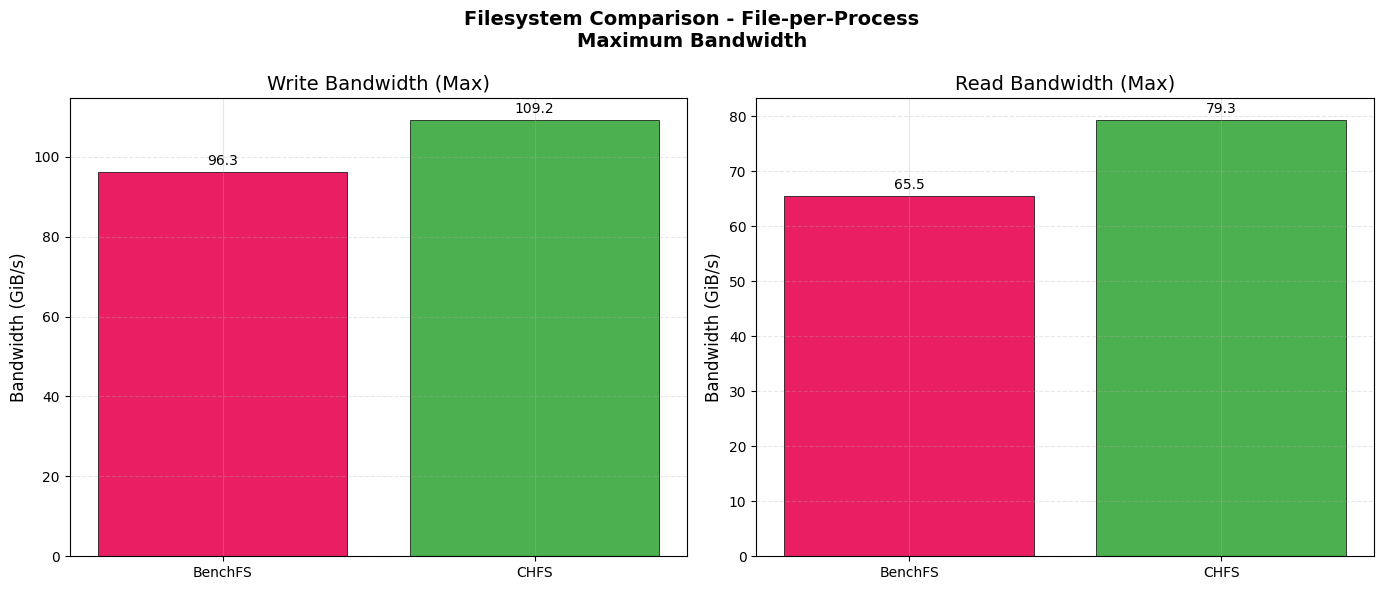

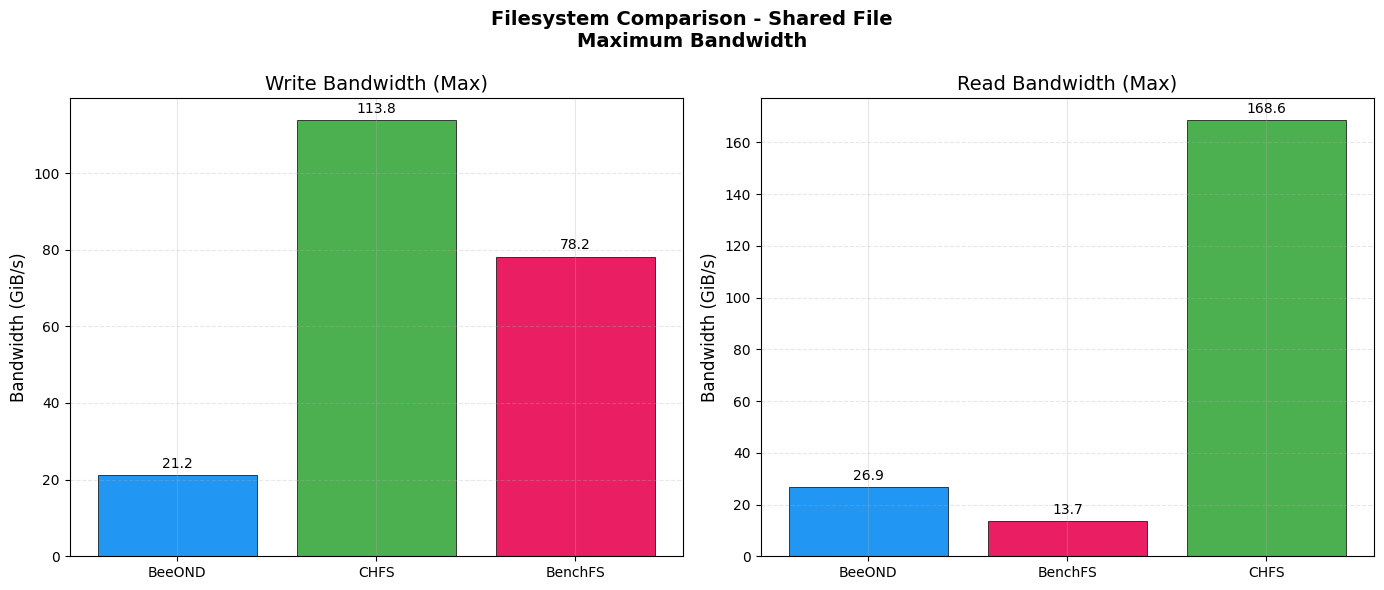

In [43]:
if all_data.is_empty():
    print("No data to plot.")
else:
    # Get max bandwidth per backend/operation/access_mode
    max_bw = (
        all_data
        .group_by(["backend", "operation", "access_mode"])
        .agg(pl.col("bw_gib").max().alias("bw_gib_max"))
    ).to_pandas()
    
    for access_mode in ["File-per-Process", "Shared File"]:
        mode_df = max_bw[max_bw["access_mode"] == access_mode]
        if mode_df.empty:
            continue
            
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        for ax, operation in zip(axes, ["write", "read"]):
            op_df = mode_df[mode_df["operation"] == operation]
            if op_df.empty:
                ax.set_title(f"No {operation} data")
                continue
            
            backends = op_df["backend"].tolist()
            bw_values = op_df["bw_gib_max"].tolist()
            colors = [FS_COLORS.get(b, 'gray') for b in backends]
            labels = [FS_LABELS.get(b, b) for b in backends]
            
            bars = ax.bar(labels, bw_values, color=colors, edgecolor='black', linewidth=0.5)
            ax.bar_label(bars, fmt='%.1f', padding=3, fontsize=10)
            
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
            ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        fig.suptitle(f'Filesystem Comparison - {access_mode}\nMaximum Bandwidth', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"comparison_max_bw_{slugify(access_mode)}")
        plt.show()
        plt.close(fig)

## Scalability Comparison

Compare how bandwidth scales with the number of nodes for each filesystem.

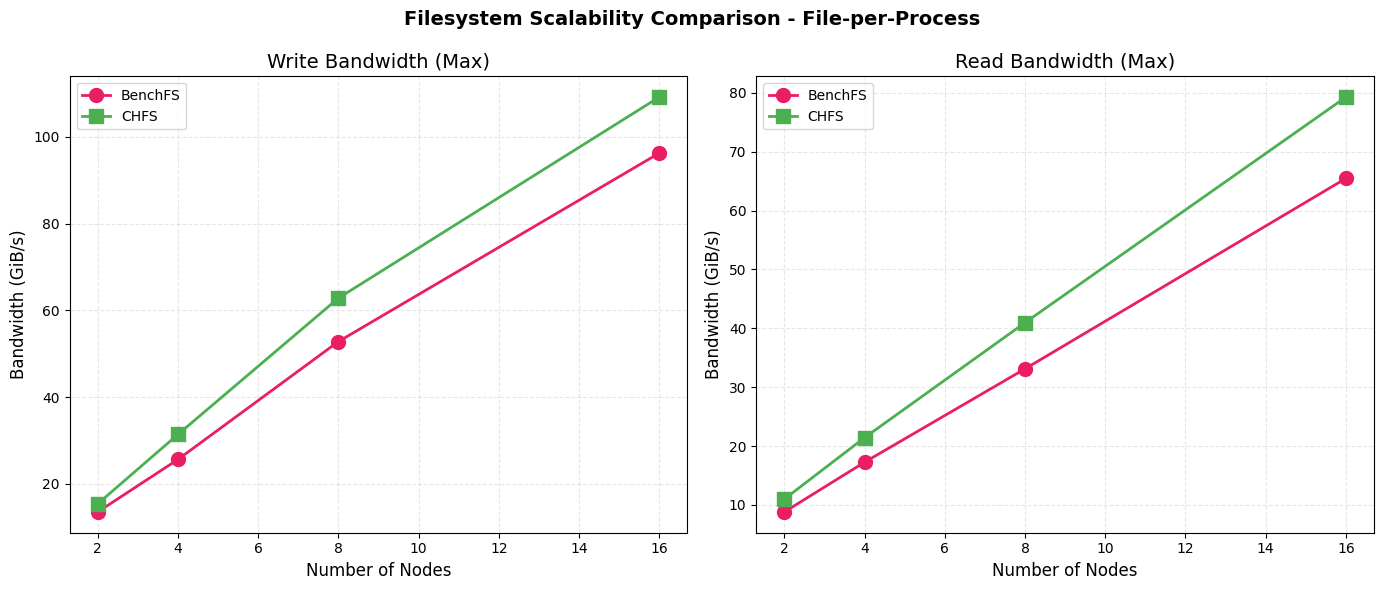

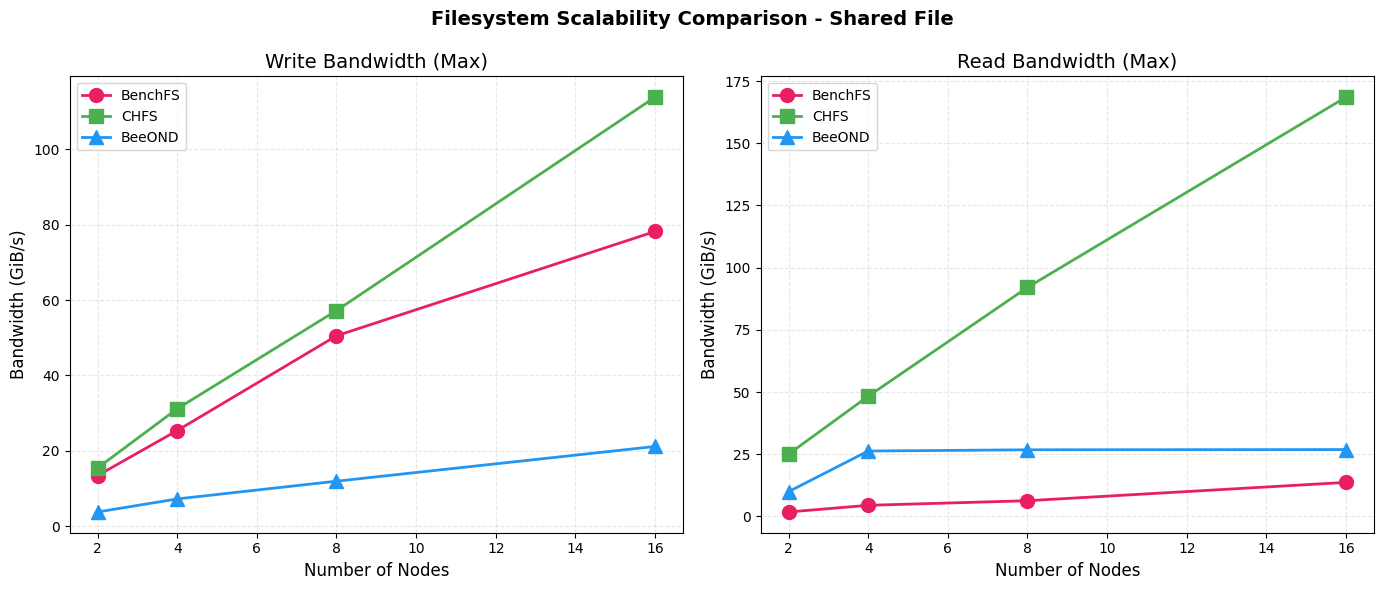

In [44]:
if all_data.is_empty():
    print("No data to plot.")
else:
    # Get max bandwidth per backend/nnodes/operation/access_mode
    scalability = (
        all_data
        .filter(pl.col("nnodes").is_not_null())
        .group_by(["backend", "nnodes", "operation", "access_mode"])
        .agg(pl.col("bw_gib").max().alias("bw_gib_max"))
        .sort(["backend", "nnodes"])
    ).to_pandas()
    
    if scalability.empty:
        print("No scalability data available.")
    else:
        for access_mode in ["File-per-Process", "Shared File"]:
            mode_df = scalability[scalability["access_mode"] == access_mode]
            if mode_df.empty:
                continue
                
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            for ax, operation in zip(axes, ["write", "read"]):
                op_df = mode_df[mode_df["operation"] == operation]
                
                for backend in ["benchfs", "chfs", "beeond"]:
                    backend_df = op_df[op_df["backend"] == backend]
                    if backend_df.empty:
                        continue
                    
                    ax.plot(
                        backend_df["nnodes"],
                        backend_df["bw_gib_max"],
                        marker=FS_MARKERS.get(backend, 'o'),
                        markersize=10,
                        linewidth=2,
                        label=FS_LABELS.get(backend, backend),
                        color=FS_COLORS.get(backend, 'gray'),
                    )
                
                ax.set_xlabel('Number of Nodes')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.legend(loc='upper left')
                ax.grid(alpha=0.3, linestyle='--')
            
            fig.suptitle(f'Filesystem Scalability Comparison - {access_mode}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"comparison_scalability_{slugify(access_mode)}")
            plt.show()
            plt.close(fig)

## Task Count Scalability

Compare bandwidth scaling with the number of MPI tasks.

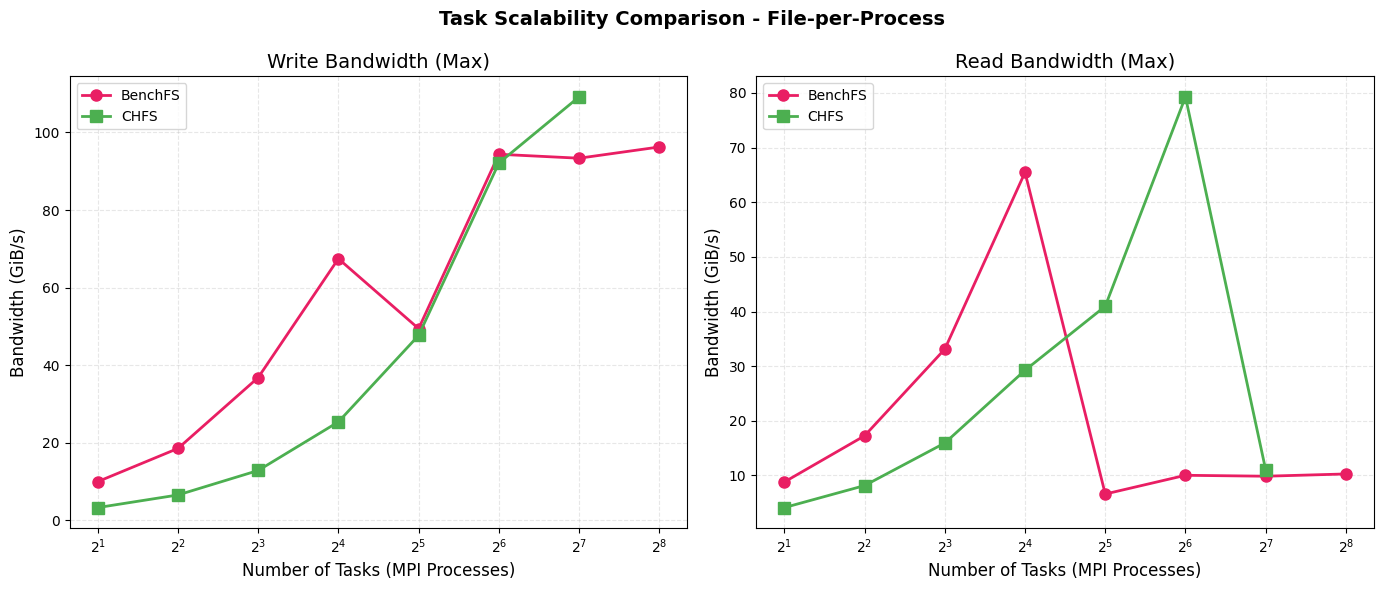

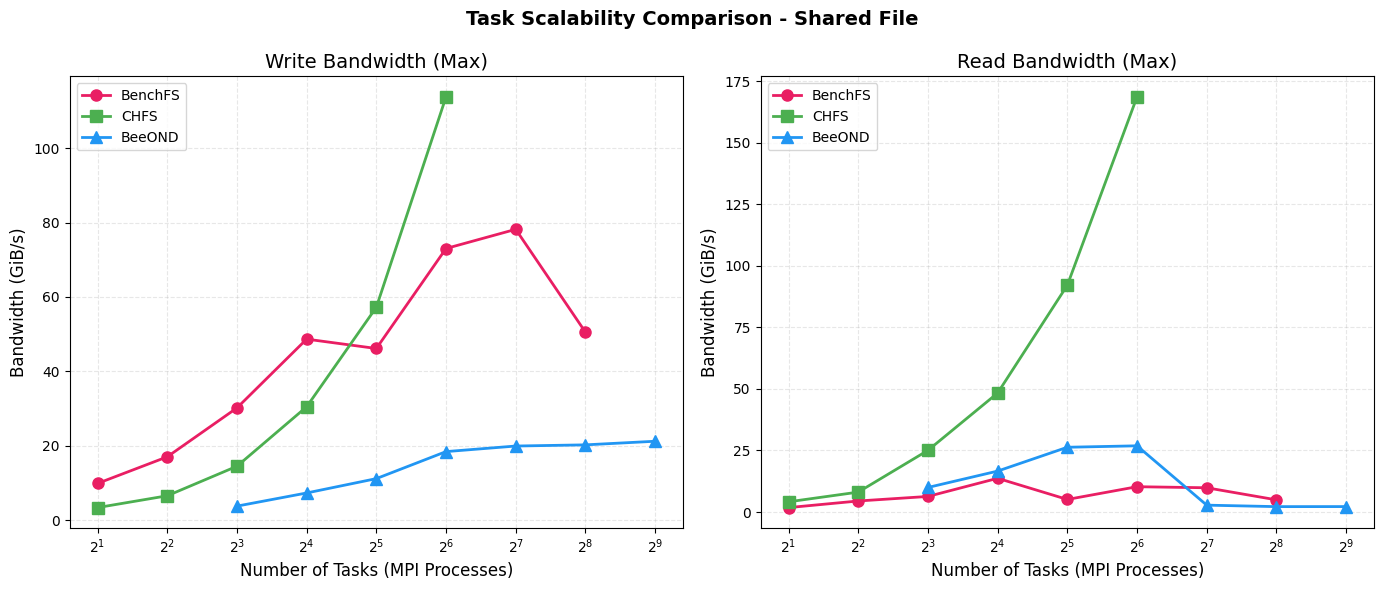

In [45]:
if all_data.is_empty():
    print("No data to plot.")
else:
    # Get max bandwidth per backend/num_tasks/operation/access_mode
    task_scalability = (
        all_data
        .filter(pl.col("num_tasks").is_not_null())
        .group_by(["backend", "num_tasks", "operation", "access_mode"])
        .agg(pl.col("bw_gib").max().alias("bw_gib_max"))
        .sort(["backend", "num_tasks"])
    ).to_pandas()
    
    if task_scalability.empty:
        print("No task scalability data available.")
    else:
        for access_mode in ["File-per-Process", "Shared File"]:
            mode_df = task_scalability[task_scalability["access_mode"] == access_mode]
            if mode_df.empty:
                continue
                
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            for ax, operation in zip(axes, ["write", "read"]):
                op_df = mode_df[mode_df["operation"] == operation]
                
                for backend in ["benchfs", "chfs", "beeond"]:
                    backend_df = op_df[op_df["backend"] == backend]
                    if backend_df.empty:
                        continue
                    
                    ax.plot(
                        backend_df["num_tasks"],
                        backend_df["bw_gib_max"],
                        marker=FS_MARKERS.get(backend, 'o'),
                        markersize=8,
                        linewidth=2,
                        label=FS_LABELS.get(backend, backend),
                        color=FS_COLORS.get(backend, 'gray'),
                    )
                
                ax.set_xlabel('Number of Tasks (MPI Processes)')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.legend(loc='upper left')
                ax.grid(alpha=0.3, linestyle='--')
                ax.set_xscale('log', base=2)
            
            fig.suptitle(f'Task Scalability Comparison - {access_mode}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"comparison_task_scalability_{slugify(access_mode)}")
            plt.show()
            plt.close(fig)

## Processes Per Node (PPN) Comparison

Compare bandwidth across different client PPN configurations.

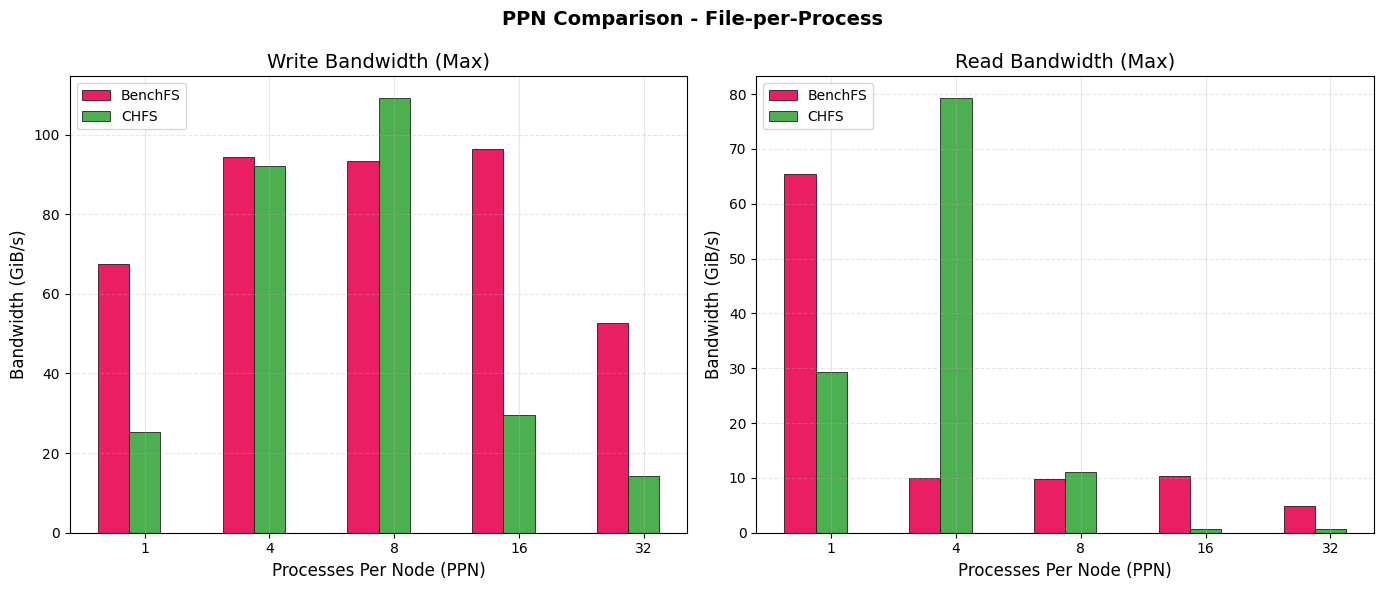

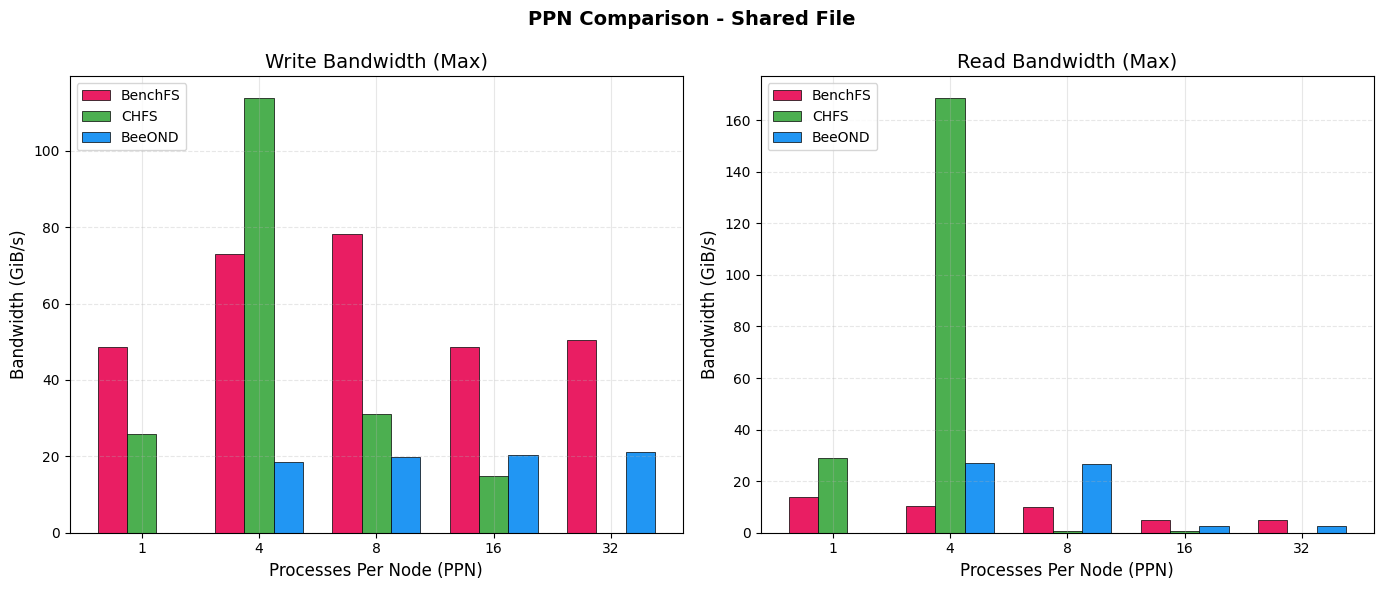

In [46]:
if all_data.is_empty():
    print("No data to plot.")
else:
    # Get max bandwidth per backend/tasks_per_node/operation/access_mode
    ppn_data = (
        all_data
        .filter(pl.col("tasks_per_node").is_not_null())
        .group_by(["backend", "tasks_per_node", "operation", "access_mode"])
        .agg(pl.col("bw_gib").max().alias("bw_gib_max"))
        .sort(["backend", "tasks_per_node"])
    ).to_pandas()
    
    if ppn_data.empty:
        print("No PPN comparison data available.")
    else:
        for access_mode in ["File-per-Process", "Shared File"]:
            mode_df = ppn_data[ppn_data["access_mode"] == access_mode]
            if mode_df.empty:
                continue
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            for ax, operation in zip(axes, ["write", "read"]):
                op_df = mode_df[mode_df["operation"] == operation]
                
                # Get all unique PPNs
                all_ppns = sorted(op_df["tasks_per_node"].unique())
                
                if len(all_ppns) == 0:
                    continue
                
                x = range(len(all_ppns))
                width = 0.25
                
                for i, backend in enumerate(["benchfs", "chfs", "beeond"]):
                    backend_df = op_df[op_df["backend"] == backend]
                    if backend_df.empty:
                        continue
                    
                    # Map PPN values to bandwidth
                    ppn_to_bw = dict(zip(backend_df["tasks_per_node"], backend_df["bw_gib_max"]))
                    bw_values = [ppn_to_bw.get(ppn, 0) for ppn in all_ppns]
                    
                    offset = (i - 1) * width
                    bars = ax.bar(
                        [xi + offset for xi in x],
                        bw_values,
                        width=width,
                        label=FS_LABELS.get(backend, backend),
                        color=FS_COLORS.get(backend, 'gray'),
                        edgecolor='black',
                        linewidth=0.5,
                    )
                
                ax.set_xlabel('Processes Per Node (PPN)')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.set_xticks(x)
                ax.set_xticklabels([int(p) for p in all_ppns])
                ax.legend(loc='upper left')
                ax.grid(axis='y', alpha=0.3, linestyle='--')
            
            fig.suptitle(f'PPN Comparison - {access_mode}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"comparison_ppn_{slugify(access_mode)}")
            plt.show()
            plt.close(fig)

## Transfer Size vs Bandwidth

Compare how bandwidth varies with different transfer sizes (xfer_size) across filesystems.

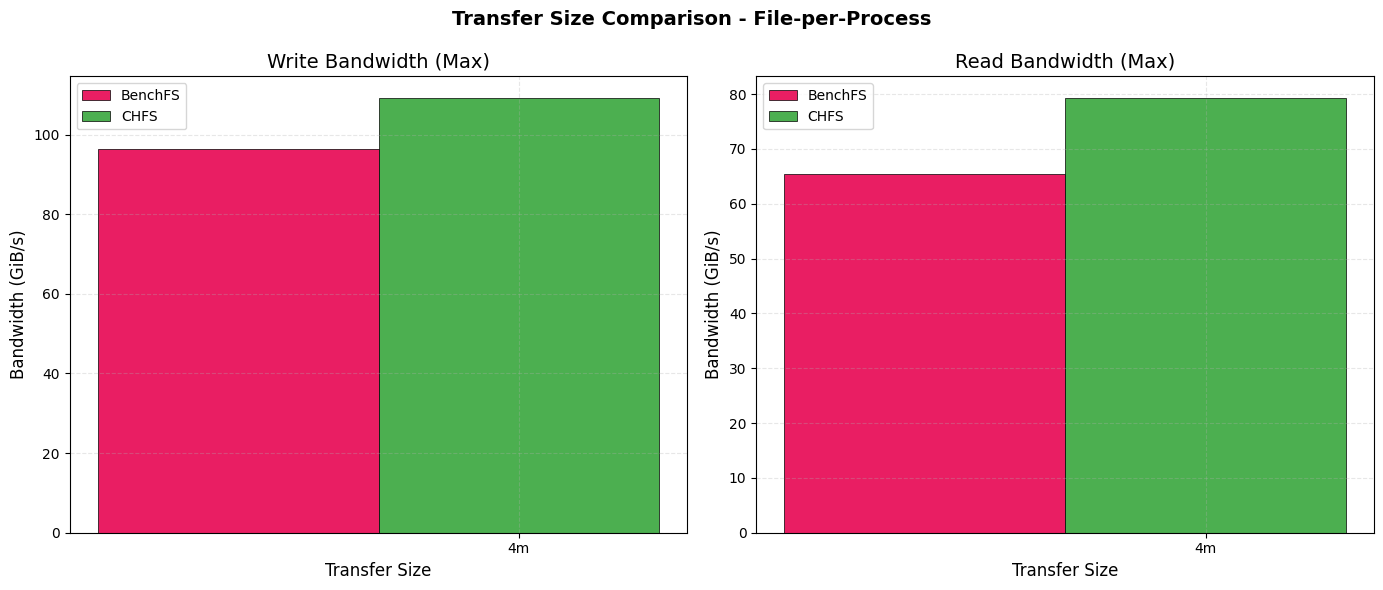

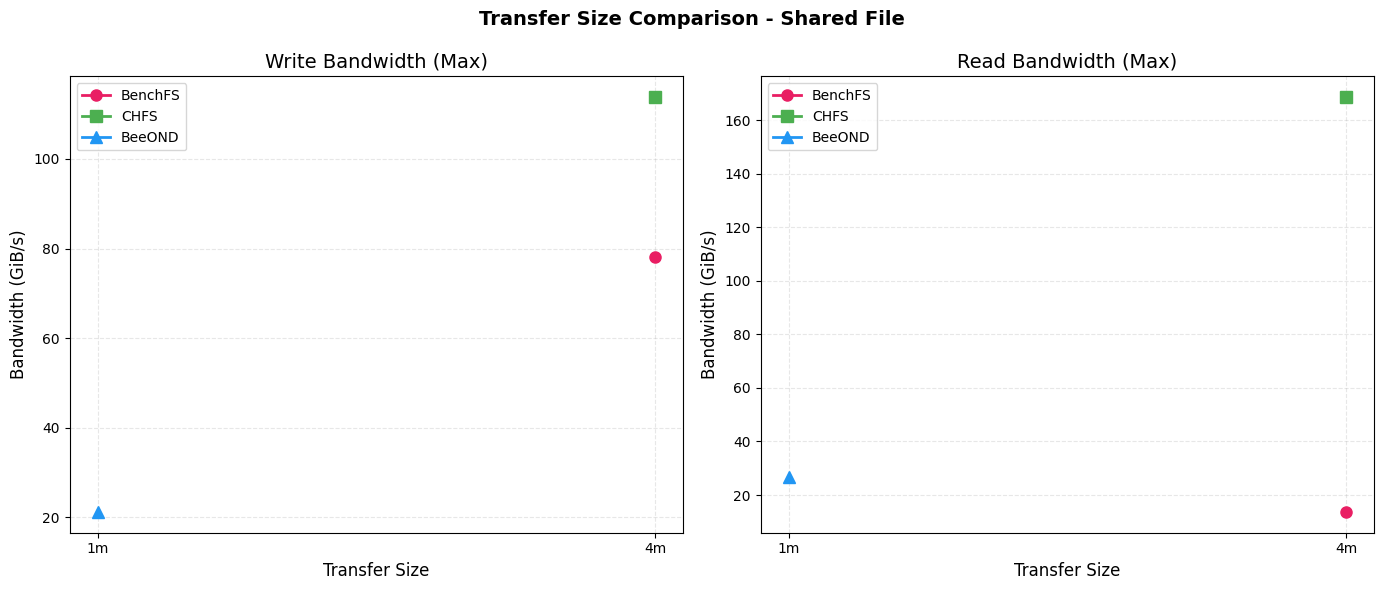

In [47]:
if all_data.is_empty():
    print("No data to plot.")
else:
    # Get max bandwidth per backend/transfer_size_str/operation/access_mode
    xfer_data = (
        all_data
        .filter(pl.col("transfer_size_str") != "")
        .group_by(["backend", "transfer_size_str", "operation", "access_mode"])
        .agg(pl.col("bw_gib").max().alias("bw_gib_max"))
    ).to_pandas()

    if xfer_data.empty:
        print("No transfer size comparison data available.")
    else:
        # Add sortable size column
        xfer_data["xfer_bytes"] = xfer_data["transfer_size_str"].apply(parse_size_to_bytes)
        xfer_data = xfer_data.sort_values("xfer_bytes")

        for access_mode in ["File-per-Process", "Shared File"]:
            mode_df = xfer_data[xfer_data["access_mode"] == access_mode]
            if mode_df.empty:
                continue

            # Get all unique transfer sizes (sorted)
            all_xfer = mode_df.drop_duplicates("transfer_size_str").sort_values("xfer_bytes")["transfer_size_str"].tolist()

            if len(all_xfer) < 1:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(14, 6))

            for ax, operation in zip(axes, ["write", "read"]):
                op_df = mode_df[mode_df["operation"] == operation]

                if len(all_xfer) > 1:
                    # Line plot for multiple transfer sizes
                    for backend in ["benchfs", "chfs", "beeond"]:
                        backend_df = op_df[op_df["backend"] == backend].sort_values("xfer_bytes")
                        if backend_df.empty:
                            continue

                        # Create mapping for x-axis positions
                        xfer_to_idx = {xfer: idx for idx, xfer in enumerate(all_xfer)}
                        x_positions = [xfer_to_idx[xfer] for xfer in backend_df["transfer_size_str"]]

                        ax.plot(
                            x_positions,
                            backend_df["bw_gib_max"],
                            marker=FS_MARKERS.get(backend, 'o'),
                            markersize=8,
                            linewidth=2,
                            label=FS_LABELS.get(backend, backend),
                            color=FS_COLORS.get(backend, 'gray'),
                        )

                    ax.set_xticks(range(len(all_xfer)))
                    ax.set_xticklabels(all_xfer)
                else:
                    # Bar chart for single transfer size
                    x = range(len(all_xfer))
                    width = 0.25

                    for i, backend in enumerate(["benchfs", "chfs", "beeond"]):
                        backend_df = op_df[op_df["backend"] == backend]
                        if backend_df.empty:
                            continue

                        xfer_to_bw = dict(zip(backend_df["transfer_size_str"], backend_df["bw_gib_max"]))
                        bw_values = [xfer_to_bw.get(xfer, 0) for xfer in all_xfer]

                        offset = (i - 1) * width
                        ax.bar(
                            [xi + offset for xi in x],
                            bw_values,
                            width=width,
                            label=FS_LABELS.get(backend, backend),
                            color=FS_COLORS.get(backend, 'gray'),
                            edgecolor='black',
                            linewidth=0.5,
                        )

                    ax.set_xticks(x)
                    ax.set_xticklabels(all_xfer)

                ax.set_xlabel('Transfer Size')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.legend(loc='upper left')
                ax.grid(alpha=0.3, linestyle='--')

            fig.suptitle(f'Transfer Size Comparison - {access_mode}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"comparison_xfer_size_{slugify(access_mode)}")
            plt.show()
            plt.close(fig)

## Block Size vs Bandwidth

Compare how bandwidth varies with different block sizes across filesystems.

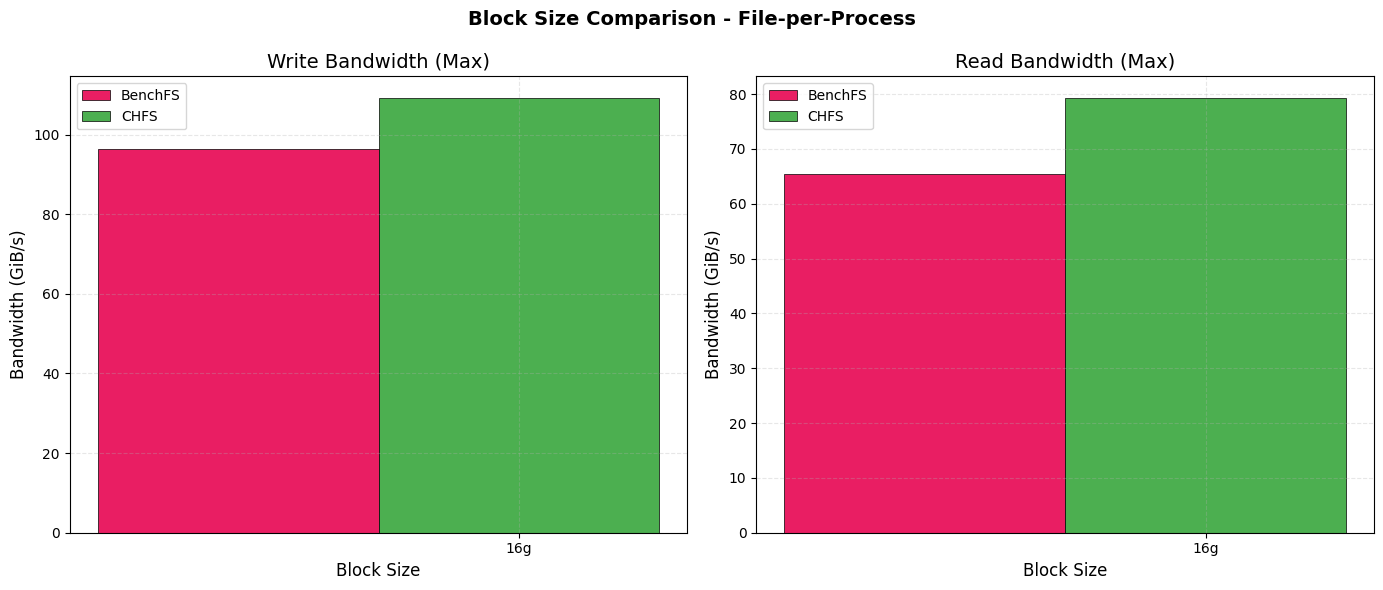

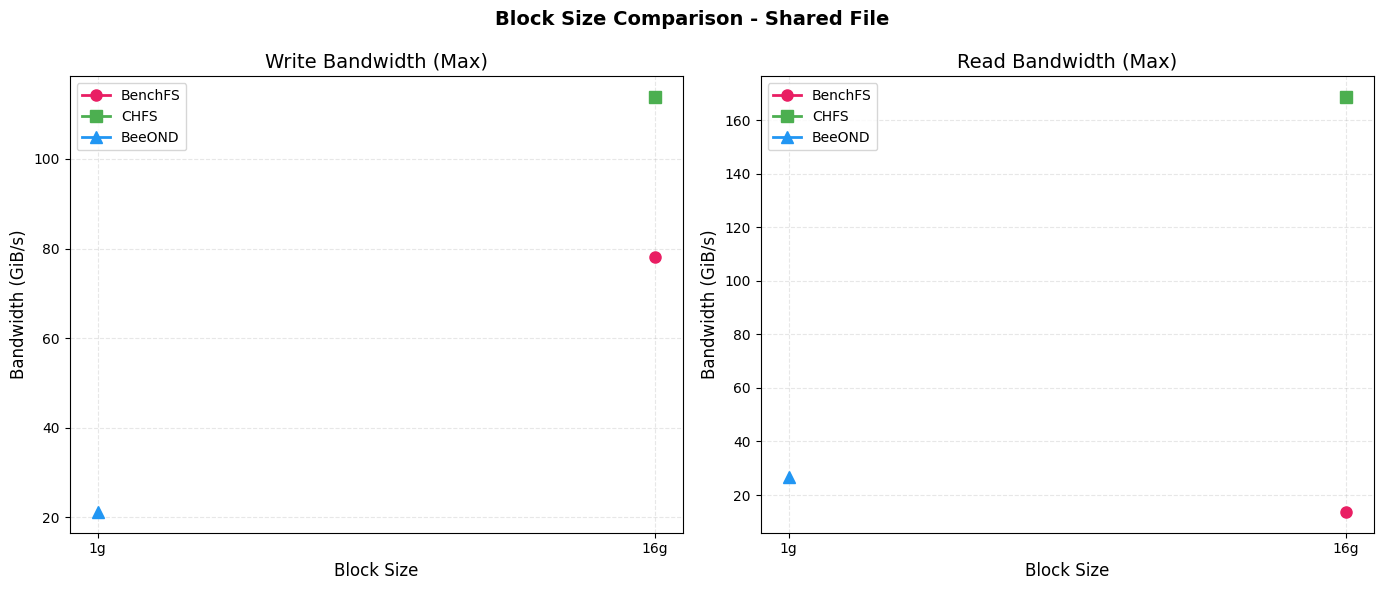

In [48]:
if all_data.is_empty():
    print("No data to plot.")
else:
    # Get max bandwidth per backend/block_size_str/operation/access_mode
    block_data = (
        all_data
        .filter(pl.col("block_size_str") != "")
        .group_by(["backend", "block_size_str", "operation", "access_mode"])
        .agg(pl.col("bw_gib").max().alias("bw_gib_max"))
    ).to_pandas()

    if block_data.empty:
        print("No block size comparison data available.")
    else:
        # Add sortable size column
        block_data["block_bytes"] = block_data["block_size_str"].apply(parse_size_to_bytes)
        block_data = block_data.sort_values("block_bytes")

        for access_mode in ["File-per-Process", "Shared File"]:
            mode_df = block_data[block_data["access_mode"] == access_mode]
            if mode_df.empty:
                continue

            # Get all unique block sizes (sorted)
            all_blocks = mode_df.drop_duplicates("block_size_str").sort_values("block_bytes")["block_size_str"].tolist()

            if len(all_blocks) < 1:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(14, 6))

            for ax, operation in zip(axes, ["write", "read"]):
                op_df = mode_df[mode_df["operation"] == operation]

                if len(all_blocks) > 1:
                    # Line plot for multiple block sizes
                    for backend in ["benchfs", "chfs", "beeond"]:
                        backend_df = op_df[op_df["backend"] == backend].sort_values("block_bytes")
                        if backend_df.empty:
                            continue

                        # Create mapping for x-axis positions
                        block_to_idx = {block: idx for idx, block in enumerate(all_blocks)}
                        x_positions = [block_to_idx[block] for block in backend_df["block_size_str"]]

                        ax.plot(
                            x_positions,
                            backend_df["bw_gib_max"],
                            marker=FS_MARKERS.get(backend, 'o'),
                            markersize=8,
                            linewidth=2,
                            label=FS_LABELS.get(backend, backend),
                            color=FS_COLORS.get(backend, 'gray'),
                        )

                    ax.set_xticks(range(len(all_blocks)))
                    ax.set_xticklabels(all_blocks)
                else:
                    # Bar chart for single block size
                    x = range(len(all_blocks))
                    width = 0.25

                    for i, backend in enumerate(["benchfs", "chfs", "beeond"]):
                        backend_df = op_df[op_df["backend"] == backend]
                        if backend_df.empty:
                            continue

                        block_to_bw = dict(zip(backend_df["block_size_str"], backend_df["bw_gib_max"]))
                        bw_values = [block_to_bw.get(block, 0) for block in all_blocks]

                        offset = (i - 1) * width
                        ax.bar(
                            [xi + offset for xi in x],
                            bw_values,
                            width=width,
                            label=FS_LABELS.get(backend, backend),
                            color=FS_COLORS.get(backend, 'gray'),
                            edgecolor='black',
                            linewidth=0.5,
                        )

                    ax.set_xticks(x)
                    ax.set_xticklabels(all_blocks)

                ax.set_xlabel('Block Size')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.legend(loc='upper left')
                ax.grid(alpha=0.3, linestyle='--')

            fig.suptitle(f'Block Size Comparison - {access_mode}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"comparison_block_size_{slugify(access_mode)}")
            plt.show()
            plt.close(fig)

## Transfer Size x Block Size Heatmap

Heatmap showing bandwidth for different combinations of transfer size and block size (per filesystem).

In [49]:
if all_data.is_empty():
    print("No data to plot.")
else:
    # Get max bandwidth per backend/transfer_size_str/block_size_str/operation/access_mode
    heatmap_data = (
        all_data
        .filter((pl.col("transfer_size_str") != "") & (pl.col("block_size_str") != ""))
        .group_by(["backend", "transfer_size_str", "block_size_str", "operation", "access_mode"])
        .agg(pl.col("bw_gib").max().alias("bw_gib_max"))
    ).to_pandas()

    if heatmap_data.empty:
        print("No heatmap data available.")
    else:
        # Add sortable columns
        heatmap_data["xfer_bytes"] = heatmap_data["transfer_size_str"].apply(parse_size_to_bytes)
        heatmap_data["block_bytes"] = heatmap_data["block_size_str"].apply(parse_size_to_bytes)

        for backend in ["benchfs", "chfs", "beeond"]:
            backend_df = heatmap_data[heatmap_data["backend"] == backend]
            if backend_df.empty:
                continue

            for access_mode in ["File-per-Process", "Shared File"]:
                mode_df = backend_df[backend_df["access_mode"] == access_mode]
                if mode_df.empty:
                    continue

                # Check if we have multiple values for both dimensions
                unique_xfer = mode_df["transfer_size_str"].nunique()
                unique_block = mode_df["block_size_str"].nunique()

                if unique_xfer < 2 or unique_block < 2:
                    continue

                fig, axes = plt.subplots(1, 2, figsize=(14, 6))

                for ax, operation in zip(axes, ["write", "read"]):
                    op_df = mode_df[mode_df["operation"] == operation]
                    if op_df.empty:
                        ax.set_title(f"No {operation} data")
                        continue

                    # Create pivot table
                    pivot = op_df.pivot_table(
                        values="bw_gib_max",
                        index="block_size_str",
                        columns="transfer_size_str",
                        aggfunc="max"
                    )

                    # Sort by size
                    block_order = sorted(pivot.index, key=lambda x: parse_size_to_bytes(x) or 0)
                    xfer_order = sorted(pivot.columns, key=lambda x: parse_size_to_bytes(x) or 0)
                    pivot = pivot.reindex(index=block_order, columns=xfer_order)

                    if pivot.empty or pivot.shape[0] < 2 or pivot.shape[1] < 2:
                        continue

                    im = ax.imshow(pivot.values, cmap='YlOrRd', aspect='auto')

                    ax.set_xticks(range(len(pivot.columns)))
                    ax.set_xticklabels(pivot.columns)
                    ax.set_yticks(range(len(pivot.index)))
                    ax.set_yticklabels(pivot.index)

                    ax.set_xlabel('Transfer Size')
                    ax.set_ylabel('Block Size')
                    ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')

                    cbar = plt.colorbar(im, ax=ax)
                    cbar.set_label('Bandwidth (GiB/s)')

                    # Add text annotations
                    for i in range(len(pivot.index)):
                        for j in range(len(pivot.columns)):
                            val = pivot.iloc[i, j]
                            if pd.notna(val):
                                text_color = 'white' if val > pivot.values[~pd.isna(pivot.values)].max() * 0.6 else 'black'
                                ax.text(j, i, f'{val:.1f}', ha='center', va='center',
                                       color=text_color, fontsize=9, fontweight='bold')

                fig.suptitle(f'{FS_LABELS.get(backend, backend)} - {access_mode}\nTransfer Size x Block Size', fontsize=14, fontweight='bold')
                plt.tight_layout()
                save(fig, f"comparison_heatmap_{backend}_{slugify(access_mode)}")
                plt.show()
                plt.close(fig)

## Summary Statistics

Detailed statistics for each filesystem.

In [50]:
if all_data.is_empty():
    print("No data available.")
else:
    stats = (
        all_data
        .group_by(["backend", "access_mode", "operation"])
        .agg([
            pl.col("bw_gib").mean().round(2).alias("Mean (GiB/s)"),
            pl.col("bw_gib").max().round(2).alias("Max (GiB/s)"),
            pl.col("bw_gib").min().round(2).alias("Min (GiB/s)"),
            pl.col("bw_gib").std().round(2).alias("Std (GiB/s)"),
            pl.col("nnodes").max().alias("Max Nodes"),
            pl.col("num_tasks").max().alias("Max Tasks"),
            pl.len().alias("Samples"),
        ])
        .sort(["backend", "access_mode", "operation"])
    )
    
    print("\nFilesystem Comparison - Summary Statistics\n")
    display(stats.to_pandas())


Filesystem Comparison - Summary Statistics



,backend,access_mode,operation,Mean (GiB/s),Max (GiB/s),Min (GiB/s),Std (GiB/s),Max Nodes,Max Tasks,Samples
0,beeond,Shared File,read,10.11,26.88,1.14,10.62,16,512,20
1,beeond,Shared File,write,9.93,21.19,3.72,5.74,16,512,20
2,benchfs,File-per-Process,read,10.16,65.47,1.26,15.38,16,256,19
3,benchfs,File-per-Process,write,40.90,96.26,10.01,29.12,16,256,19
4,benchfs,Shared File,read,4.54,13.69,1.24,3.56,16,256,18
5,benchfs,Shared File,write,33.52,78.19,9.84,20.88,16,256,18
6,chfs,File-per-Process,read,15.13,79.29,0.65,21.43,16,128,15
7,chfs,File-per-Process,write,33.52,109.17,3.32,31.54,16,128,15
8,chfs,Shared File,read,36.97,168.56,0.65,46.45,16,64,15
9,chfs,Shared File,write,33.68,113.81,3.35,32.11,16,64,15


## Export Data

Export processed comparison data to JSON.

In [51]:
if all_data.is_empty():
    print("No data to export.")
else:
    output_file = DATA_DIR / "comparison_data.json"
    output_file.write_text(
        json.dumps(all_data.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
    )
    print(f"Wrote {output_file}")
    
    # Export summary stats
    stats_file = DATA_DIR / "comparison_stats.json"
    stats_file.write_text(
        json.dumps(stats.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
    )
    print(f"Wrote {stats_file}")

Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/comparison/comparison_data.json
Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/comparison/comparison_stats.json
